In [1]:
%matplotlib widget
from PIL import Image

import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from trainer import SegmentationMaskTrainer

In [5]:
arr = np.arange(9).reshape((3, 3))
np.broadcast_to(arr, (2, 3,3)).shape

(2, 3, 3)

In [7]:
with Image.open('/home/somahansel/developer/omnimotion/data/rollerblade/mnt/data/data_release/rollerblade/raft_masks/00000.jpg_00001.jpg.png') as r:
    raft_m = np.array(r)

In [13]:
raft_m.shape

(480, 854, 3)

In [15]:
init_data = [23, 47]
with Image.open('/home/somahansel/developer/omnimotion/data/lab-coat/mnt/data/data_release/lab-coat/mask/000{}.png'.format(init_data[0])) as im_mask:
    init_mask = np.array(im_mask) > 0
init_data.append(init_mask)

In [41]:
consistency_mask = np.empty((init_data[1], init_data[1], *init_mask.shape), dtype=bool)
occlusion_mask = np.empty((init_data[1], init_data[1], *init_mask.shape), dtype=bool)
combined_mask = np.empty((init_data[1], init_data[1], *init_mask.shape), dtype=bool)
for i in range(init_data[1]):
    for j in range(init_data[1]):
        if i == j:
            continue
        i_filled = str(i).zfill(5)
        j_filled = str(j).zfill(5)
        with Image.open('/home/somahansel/developer/omnimotion/data/lab-coat/mnt/data/data_release/lab-coat/raft_masks/{}.jpg_{}.jpg.png'.format(j_filled, i_filled)) as r:
            raft_m = np.array(r)
        consistency_mask[i, j] = raft_m[..., 0] > 0
        occlusion_mask[i, j] = raft_m[..., 1] > 0
        if abs(i - j) == 1:
            combined_mask[i, j] = np.ones_like(consistency_mask[i, j])
        else:
            combined_mask[i, j] = np.logical_or(consistency_mask[i, j], occlusion_mask[i, j])

In [17]:
flows = np.empty((init_data[1], init_data[1], *init_mask.shape, 2))
for i in range(init_data[1]):
    for j in range(init_data[1]):
        if i == j:
            continue
        i_filled = str(i).zfill(5)
        j_filled = str(j).zfill(5)
        flows[i, j] = np.load('/home/somahansel/developer/omnimotion/data/lab-coat/mnt/data/data_release/lab-coat/raft_exhaustive/{}.jpg_{}.jpg.npy'.format(j_filled, i_filled))
        

In [26]:
consistency_mask.shape, occlusion_mask.shape, flows.shape

((47, 47, 480, 854), (47, 47, 480, 854), (47, 47, 480, 854, 2))

In [32]:
flows[consistency_mask].shape

(448564843, 2)

In [5]:
init_data[2] = np.array(init_data[2], dtype=np.double)
flows = torch.tensor(flows)
trainer = SegmentationMaskTrainer(init_data=init_data, flows=flows, device='cpu', time_window=5)

/tmp/ipykernel_430435/3926904651.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  flows = torch.tensor(flows)
/home/somahansel/anaconda3/envs/omnimotion/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [27]:
trainer.optim.zero_grad()
loss = trainer.calculate_gradient()
loss.backward()
trainer.optim.step()

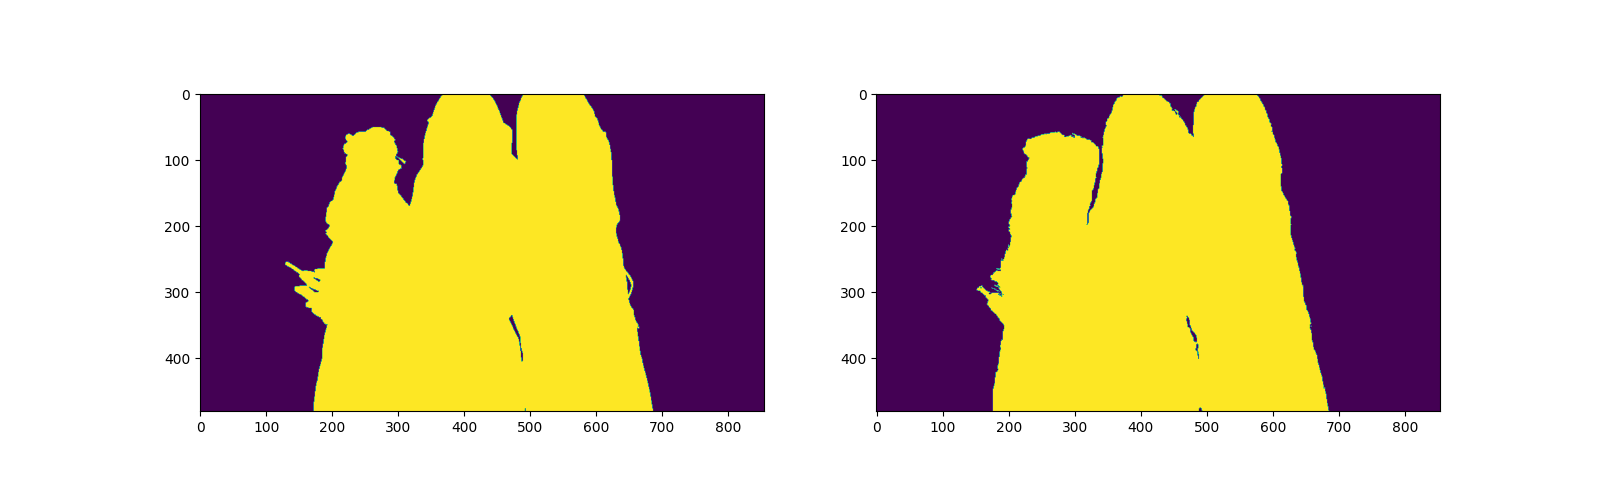

In [18]:
init_seg_mask = trainer.seg_masks
im_index = 30
with Image.open('/home/somahansel/developer/omnimotion/data/lab-coat/mnt/data/data_release/lab-coat/mask/{}.png'.format(str(im_index).zfill(5))) as im_mask:
    orig_mask = np.array(im_mask) > 0
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(16, 5)
ax[0].imshow(orig_mask)
ax[1].imshow(init_seg_mask[im_index].detach().numpy())
plt.show()

In [44]:
# TODO: from omnimotion
def gen_grid(h, w, device):
    lin_y = torch.arange(0, h, device=device)
    lin_x = torch.arange(0, w, device=device)
    grid_y, grid_x = torch.meshgrid((lin_y, lin_x))
    grid = torch.stack((grid_x, grid_y), -1)
    return grid  # [h, w, 2]

# TODO: from omnimotion
def normalize_coords(coords, h, w, no_shift=False):
    assert coords.shape[-1] == 2
    return coords / torch.tensor([w-1., h-1.], device=coords.device) * 2 - 1.

def apply_flow_to_frame(flow, frame, device):
    #TODO: cite omnimotion
    h, w = frame.shape[-2:]
    grid = gen_grid(h, w, device=device)
    new_coords = flow + grid
    new_coords_normed = normalize_coords(new_coords, h, w)  # [h, w, 2]
    new_frame = torch.nn.functional.grid_sample(frame, new_coords_normed, align_corners=True)
    return new_frame

In [37]:
num1 = '00022'
num2 = '00025'
with Image.open('/home/somahansel/developer/omnimotion/data/rollerblade/mnt/data/data_release/rollerblade/color/{}.jpg'.format(num1)) as im_mask:
    mask1 = np.array(im_mask, dtype=np.float32)
with Image.open('/home/somahansel/developer/omnimotion/data/rollerblade/mnt/data/data_release/rollerblade/color/{}.jpg'.format(num2)) as im_mask:
    mask2 = np.array(im_mask, dtype=np.float32)
flow = np.load('/home/somahansel/developer/omnimotion/data/rollerblade/mnt/data/data_release/rollerblade/raft_exhaustive/{}.jpg_{}.jpg.npy'.format(num1, num2))
flow2 = np.load('/home/somahansel/developer/omnimotion/data/rollerblade/mnt/data/data_release/rollerblade/raft_exhaustive/{}.jpg_{}.jpg.npy'.format(num2, num1))

In [42]:
flow = flow[consistency_mask[int(num1), int(num2)]]
flow2 = flow2[consistency_mask[int(num2), int(num1)]]

In [45]:
# b, c, h, w = mask1.shape
# grid = gen_grid(h, w, device='cpu')
out2 = apply_flow_to_frame(torch.from_numpy(flow).unsqueeze(0), torch.from_numpy(mask2).permute(2, 0, 1).unsqueeze(0), device='cpu')
out  = apply_flow_to_frame(torch.from_numpy(flow2).unsqueeze(0), torch.from_numpy(mask1).permute(2, 0, 1).unsqueeze(0), device='cpu')

/home/somahansel/anaconda3/envs/omnimotion/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


RuntimeError: The size of tensor a (387344) must match the size of tensor b (854) at non-singleton dimension 1

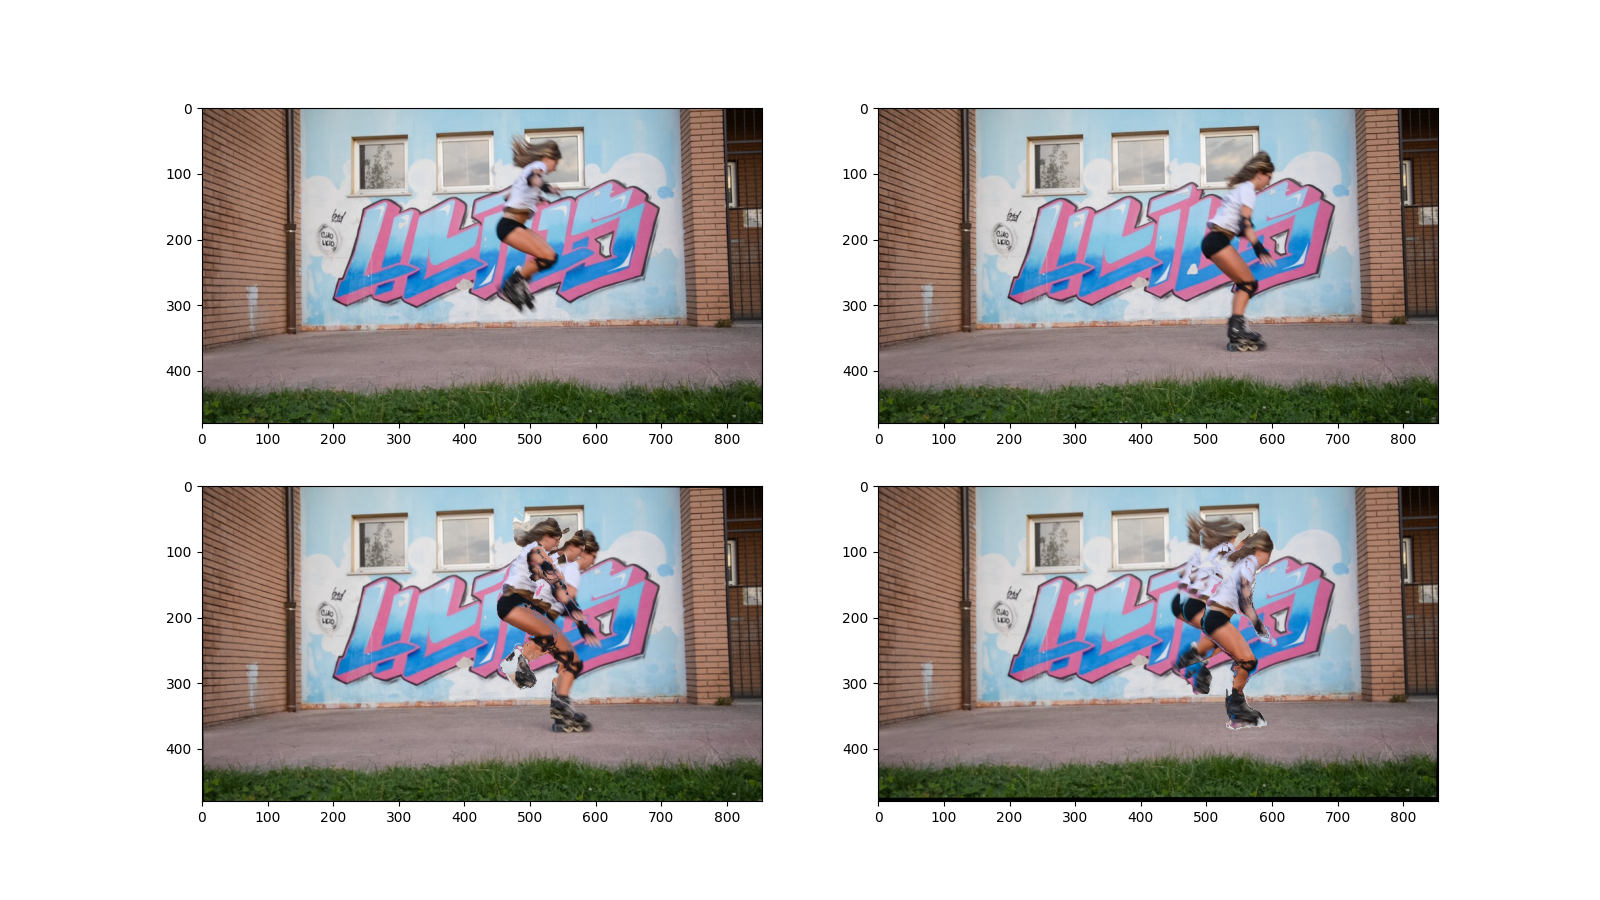

In [25]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
ax[0, 0].imshow(mask1/mask1.max())
ax[0, 1].imshow(mask2/mask2.max())
ax[1, 0].imshow(out2.squeeze().permute(1, 2, 0)/out2.max())
ax[1, 1].imshow(out.squeeze().permute(1, 2, 0)/out.max())
plt.show()

In [6]:
plt.imshow(out.squeeze())
plt.show()

TypeError: Invalid shape (3, 480, 854) for image data